# Mission Analysis and Orbital Mechanics Assignment - Exercise 3
Auxilliary calculation functions can be found in the file solvers_calculators.py

In [65]:
import numpy as np
from constants import *
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

### ISS:
- equatorial orbit
- 404 km above the earth
### Chaser:
- apogee = R_ISS
- angular separation = delta_theta
- catches up to ISS in N_rev orbits

In [66]:
R_ISS = R_EARTH + 404  # km
D_THETA = np.radians(100)  # initial angular separation in radians

v0_mod = np.sqrt(G_EARTH / R_ISS)

r0 = np.array([R_ISS * np.cos(D_THETA), R_ISS * np.sin(D_THETA), 0])
v0 = np.array([-v0_mod * np.sin(D_THETA), v0_mod * np.cos(D_THETA), 0])

X0 = np.concatenate((r0, v0))

# 2.5 hours (a bit more than the period)
ts = np.arange(0, 3600 * 2.5, 10)

def twobody(_, X):
    return np.concatenate((X[3:], - G_EARTH * X[:3] / np.power(np.linalg.norm(X[:3]), 3)))

sol = solve_ivp(twobody, [0, np.max(ts)], X0, t_eval=ts, rtol=1e-12, atol=1e-12, vectorized=True)
pos = sol.y[:3, :]
vels = sol.y[3:, :]

pos2d = pos[:2, :]
vels2d = vels[:2, :]

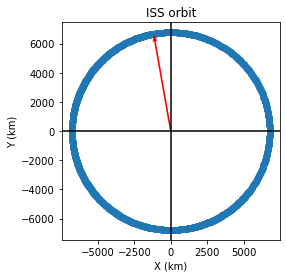

In [67]:
# time vs magnitude of the velocity vector
plt.scatter(*pos2d)
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.title("ISS orbit")
plt.gca().set_aspect('equal')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.quiver(0, 0, *r0[:2], color=['r'], angles='xy', scale_units='xy', scale=1)
plt.show()

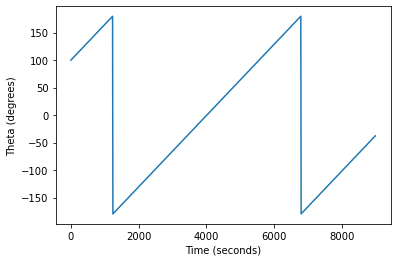

5560.0
5558.375715461923


In [68]:
thetas = np.arctan2(pos[1, :], pos[0, :])

plt.plot(ts, np.degrees(thetas))
plt.xlabel("Time (seconds)")
plt.ylabel("Theta (degrees)")
plt.show()

# period computation from obtained thetas: time until theta is 100 again
print(ts[np.where(np.abs(thetas - D_THETA) < 1e-2)][-1])

# exact period computation
T_ISS = 2*np.pi*np.sqrt(np.power(R_ISS, 3) / G_EARTH)
print(T_ISS)  # the difference between the two comes from the fact we are considering time in increments of 10 seconds

In [82]:
N_REV = 12
a_chaser = np.power(1 - D_THETA / (2 * np.pi * N_REV), 2/3) * R_ISS
print(f"{a_chaser=}")

e_chaser = R_ISS / a_chaser - 1
print(f"{e_chaser=}")

a_chaser=6676.931512285589
e_chaser=0.015736043947895073
